In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.patches as mpatches

# Neural Mechanics: The Dynamics of Learning

As identified in [*Neural Mechanics: Symmetry and Broken Conservation Laws*](https://arxiv.org/abs/2012.04728), we can model SGD using an ODE modifying gradient flow.  While this work idenitified essential aspects of the training trajectory through parameter space through the lens of symmetry, it failed to understand how this trajectory coupled with the performance of the model in terms of the training loss.  The goal of this notebook is to explore ways of making this connection.

## Gradient Dissipation - A PDE describing the dynamics of the loss under gradient flow

Lets consider the gradient flow equation of motion $\frac{d\theta}{dt} = - g$ where $g = \frac{\partial \mathcal{L}}{\partial \theta}$. Under this equation of motion, then the temporal dynamics for the loss can be described as
$$\frac{\partial \mathcal{L}}{\partial t} = \frac{\partial \mathcal{L}}{\partial \theta}\frac{\partial \theta}{\partial t}$$
If can replace $\frac{\partial \theta}{\partial t}$ with the gradient flow equation and rearrange, then we get the first order quasilinear PDE
$$\partial_t \mathcal{L} + \sum_{i}g_i\partial_{\theta_i}\mathcal{L} = 0$$
What is a solution $\mathcal{L}(t,\theta)$ to this PDE?  At the boundary condition $t=0$, then $\mathcal{L}(0,\theta)$ is the original training loss landscape. For $t > 0$, then $\mathcal{L}(t,\theta)$ represents the value of the loss after $t$ time of gradient flow training starting from $\theta$ initialization. Can we solve this PDE?  Can this perspective shed light on the dynamics of the loss?  Lets consider an example.

#### Scalar Quadratic - $\mathcal{L}(\theta) = \theta^2$

We will start by considering the simple example of a scalar quadtraic.  In this case the gradient flow dynamics are $\frac{d\theta}{dt} = -\theta$ and the PDE is
$$\partial_t \mathcal{L} + \theta \partial_\theta \mathcal{L} = 0$$

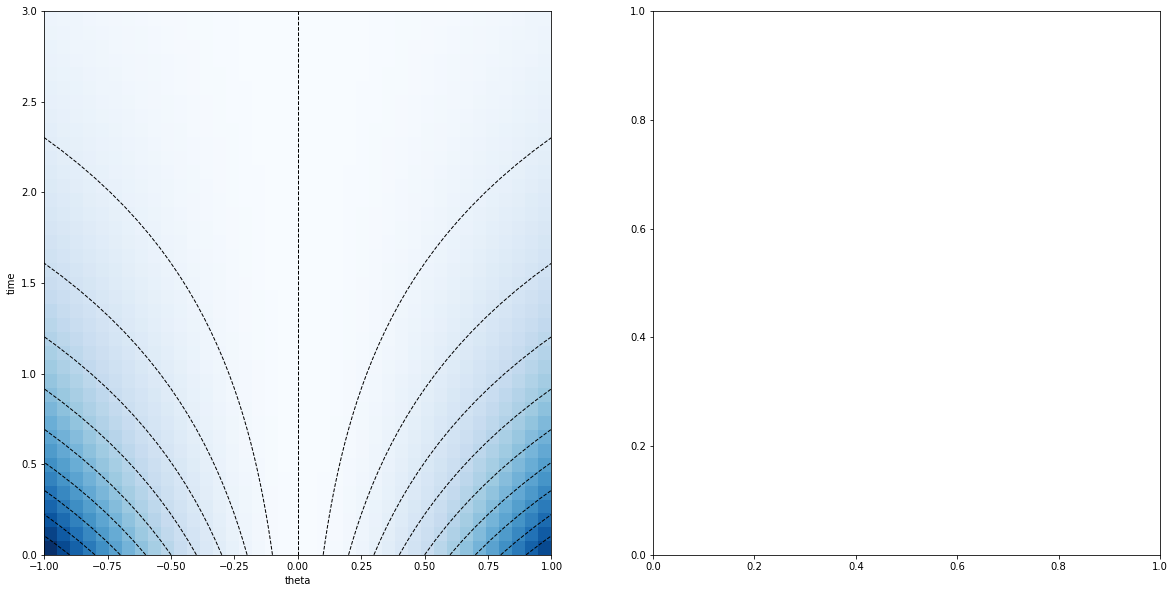

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

# Plot L(t,x)
t, x = np.meshgrid(np.linspace(0, 3, 40), np.linspace(-1, 1, 40))
L = x**2 * np.exp(-t) / 2
axs[0].pcolormesh(x, t, L, cmap='Blues')

# Plot characteristics
for r in np.linspace(-1, 1, 21):
    time = np.linspace(0, 3, 40)
    axs[0].plot(r * np.exp(time), time, color='k', lw=1, ls='--', zorder=100)

# Plot lims
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([0, 3])

# Plot labels
axs[0].set_xlabel("theta")
axs[0].set_ylabel("time")

plt.show()


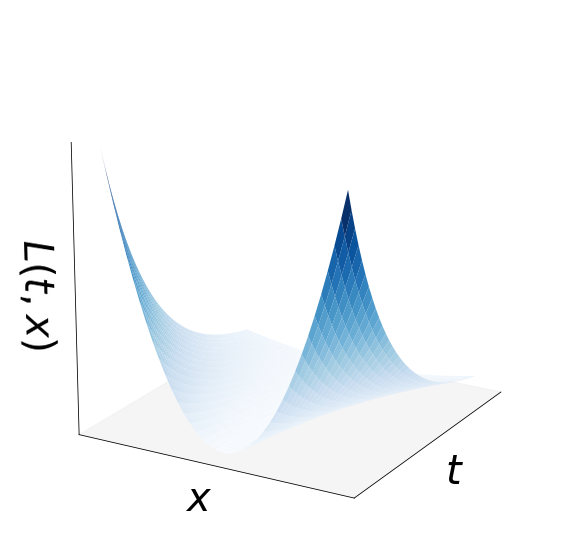

In [4]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

# cartesian grid
t, x = np.meshgrid(np.linspace(0, 3, 40), np.linspace(-1, 1, 40))
# L = x**2 * (t + 0.5)/(2*t + 1)**2
L = x**2 * np.exp(-t) / 2

# surface plot
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('$t$', size=40, weight='light')
ax.set_ylabel('$x$', size=40, weight='light')
ax.set_zlabel('$L(t,x)$', size=40, weight='light')


ax.view_init(elev=20, azim=-150)
ax.plot_surface(t, x, L, rstride=1, cstride=1, cmap='Blues', shade=1)


0.2579957740428628 3.881561558898365


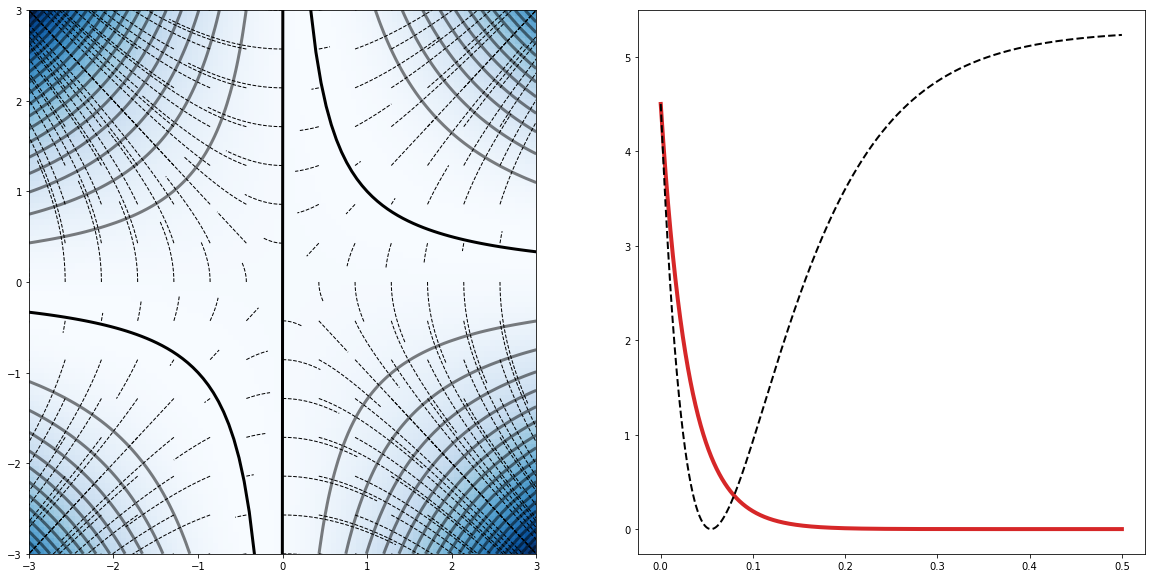

In [22]:
def gradient_flow(w10, w20, num_steps, eta):
    w1 = [w10]
    w2 = [w20]
    for i in range(num_steps):
        g1 = w2[-1]*(w2[-1]*w1[-1] - 1)
        g2 = w1[-1]*(w2[-1]*w1[-1] - 1)
        w1.append(w1[-1] - eta * g1)
        w2.append(w2[-1] - eta * g2)
    return w1, w2

def characteristic(r1, r2, time):
    alpha = r2 * r1 - 1
    
    c0 = np.exp(-alpha * time) / 2
    c1 = np.exp(2 * alpha * time) + 1
    c2 = np.exp(2 * alpha * time) - 1
    
    w1 = c0 * (r1 * c1 + r2 * c2)
    w2 = c0 * (r1 * c2 + r2 * c1)
    
    return w1, w2

def theory(w10, w20, time):
    alpha = w20*w10 - 1
    
    c0 = np.exp(-2*alpha * time) / 2
    c1 = np.exp(2 * alpha * time) + 1
    c2 = np.exp(2 * alpha * time) - 1
    
    r1 = c0 * (w10 * c1 - w20 * c2)
    r2 = c0 * (w20 * c1 - w10 * c2)
    
    return 0.5 * (r2 * r1 - 1)**2

def loss(w1, w2):
    w1 = np.array(w1)
    w2 = np.array(w2)
    return 0.5 * (w2 * w1 - 1)**2
    

fig, axs = plt.subplots(1, 2, figsize=(20,10))
eta=0.00001
num_steps = 50000
w10 = 1
w20 = 4

gf_1, gf_2 = gradient_flow(w10, w20, num_steps, eta)

axs[0].plot(gf_1, gf_2, color=plt.cm.tab10(3), lw=4)
axs[0].scatter(w10, w20, color='w', zorder=120, s=200, edgecolors='k', linewidth=3) 

time = eta*np.arange(0,num_steps+1)
axs[1].plot(time,loss(gf_1,gf_2), color=plt.cm.tab10(3), lw=4)
axs[1].plot(time,theory(w10, w20, time), color='k', lw=2, ls='--')

print(gf_1[-1], gf_2[-1])
w1, w2 = characteristic(gf_1[-1], gf_2[-1], time)
axs[0].plot(w1, w2, color='b', lw=2, ls='-', zorder=100)
for r1 in np.linspace(-3, 3, 15):
    for r2 in np.linspace(-3, 3, 15):
        w1, w2 = characteristic(r1, r2, time)
        axs[0].plot(w1, w2, color='k', lw=1, ls='--')


w1, w2 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
L = loss(w1, w2)


axs[0].plot(np.linspace(-3,3,100), 1/np.linspace(-3,3,100), color='k', lw=3, ls='-', zorder=100)

axs[0].contour(w1, w2, L, np.linspace(0, np.max(L), 20), colors=['k'], alpha=0.5, linewidths=3)
axs[0].pcolormesh(w1, w2, L, cmap='Blues')
axs[0].set_xlim([-3, 3])
axs[0].set_ylim([-3, 3])

plt.show()